In [1]:
#TO DO - PLAY AROUND WITH SMT PARAMETERS UNTIL YOU GET SENSIBLE FA/MD! CAN MATCH SMT MAX/MIN TO HCP DATA FIT

#write simulation funct#[noiseless, directional] signal and model and ROImask [dti], set random seedion that outputs ground truth 



#TO DO CALCULATE BIAS AND VARIANCE


#Paddy to do: 1. test-restest simulations; 2. "lesion" simulation
#Paddy. 3. rois based on clustering from lsq fit - can do kmeans etc, might need a bit of tuning but should be ok







In [2]:
#TO DO - SIMULATIONS USING THE GAUSSIAN MIXTURE MODEL FIT
#TO DO - PLOT FITTED GIBBS VALUES AGAINST TRUE CLUSTERS


#TO DO: STORE JUMPING VARIANCES AND VALUES OF PRIOR/LIKELIHOOD 

In [3]:
#load modules
import numpy as np
import matplotlib.pyplot as plt
import os


In [4]:
#set the random seed so that you get the same simulations
np.random.seed(seed=1)

In [5]:
#set up the MC-SMT model
from dmipy.signal_models import cylinder_models, gaussian_models
stick = cylinder_models.C1Stick()
zeppelin = gaussian_models.G2Zeppelin()


from dmipy.distributions.distribute_models import BundleModel
bundle = BundleModel([stick, zeppelin])
bundle.set_tortuous_parameter('G2Zeppelin_1_lambda_perp',
    'C1Stick_1_lambda_par','partial_volume_0')
bundle.set_equal_parameter('G2Zeppelin_1_lambda_par', 'C1Stick_1_lambda_par')
bundle.set_equal_parameter('G2Zeppelin_1_mu', 'C1Stick_1_mu')


#set up two models - directional and direction averaged

from dmipy.core import modeling_framework
mc_smt_mod = modeling_framework.MultiCompartmentSphericalMeanModel(
    models=[bundle])
mc_smt_mod.parameter_names


mc_mod = modeling_framework.MultiCompartmentModel(
    models=[bundle])
mc_mod.parameter_names



['BundleModel_1_G2Zeppelin_1_mu',
 'BundleModel_1_G2Zeppelin_1_lambda_par',
 'BundleModel_1_partial_volume_0']

In [6]:
#array of the number of voxels for multiple tissue types
n_tissue = np.array((400,300))

n_ROI = len(n_tissue)

n_vox = np.sum(n_tissue)

n_param=2

#choose some parameters for the simulated SMT-NODDI model for each of the ROIs 
#Gaussian distribution with mean and covariance matrix

#first parameter is lambda_par
ROImeans = np.zeros((n_param,n_ROI))
ROIcovs = np.zeros((n_param,n_param,n_ROI))

ROImeans[:,0] = np.array((2.5e-9, 0.8)) #~WM
ROImeans[:,1] = np.array((1.5e-9, 0.4)) #~GM

ROIcovs[:,:,0] = np.array(((1e-22,0),(0,0.0001))) #~WM
ROIcovs[:,:,1] = np.array(((1e-22,0),(0,0.0001))) #~WM


mu_1 = [0, np.pi]
mu_2 = [-np.pi,np.pi]

#angles are the same for all ROIs
mu_1 = np.random.uniform(low=mu_1[0],high=mu_1[1],size=n_vox)
mu_2 = np.random.uniform(low=mu_2[0],high=mu_2[1],size=n_vox)

mu = np.stack((mu_1,mu_2),axis=1)


#fill up first ROIs mask and parameters
ROImask_gt = np.ones((n_tissue[0],))

ROI_params = np.random.multivariate_normal(ROImeans[:,0], ROIcovs[:,:,0], n_tissue[0])

lambda_par = ROI_params[:,0]
f_stick = ROI_params[:,1]




#loop through ROIs and fill up parameter vectors and ROI mask
for j in range(1,n_ROI):    
    print(j)
    ROImask_gt = np.append(ROImask_gt, (j+1)*np.ones((n_tissue[j],)))

    ROI_params = np.random.multivariate_normal(ROImeans[:,j], ROIcovs[:,:,j], n_tissue[j])

    lambda_par = np.append(lambda_par, ROI_params[:,0])
    f_stick = np.append(f_stick,ROI_params[:,1])


    
    
#put into a big parameter vector that can be passed into simulate_signal
parameters_vector = mc_mod.parameters_to_parameter_vector(BundleModel_1_G2Zeppelin_1_mu=mu,
                                                                BundleModel_1_G2Zeppelin_1_lambda_par=lambda_par,
                                                                BundleModel_1_partial_volume_0=f_stick)
                                                        

    

1


In [7]:
# datadir = '/Users/paddyslator/OneDrive - University College London/data/bayes-dmipy/'

# from sklearn.mixture import GaussianMixture

# # load the GMM on SMT fit to HCP 
# # GMM
# means = np.load(os.path.join(datadir, 'gmm_hcp_fit_means.npy'))
# covar = np.load(os.path.join(datadir, 'gmm_hcp_fit_covariances.npy'))
# gmm = GaussianMixture(n_components = len(means), covariance_type='full')
# gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covar))
# gmm.weights_ = np.load(os.path.join(datadir, 'gmm_hcp_fit_weights.npy'))
# gmm.means_ = means
# gmm.covariances_ = covar

# import random

# n_vox = 500
# #sample from GMM 
# params,ROImask_gt = gmm.sample(2*n_vox)

# #remove anything that's outside the bounds
# outside = (params[:,0] < 0) | (params[:,0] > 3) | (params[:,1] < 0) | (params[:,1] > 1)
# params = params[~outside,:]
# ROImask_gt = ROImask_gt[~outside]

# #trim down to the number of voxels
# to_keep = np.sort(random.sample(range(0,np.sum(~outside)),n_vox)) 
    
# params = params[to_keep,:]
# ROImask_gt = ROImask_gt[to_keep]

# #reindex
# ROImask_gt = ROImask_gt + 1

# #sample the directions uniformly
# mu_1 = [0, np.pi]
# mu_2 = [-np.pi,np.pi]

# mu_1 = np.random.uniform(low=mu_1[0],high=mu_1[1],size=n_vox)
# mu_2 = np.random.uniform(low=mu_2[0],high=mu_2[1],size=n_vox)
# mu = np.stack((mu_1,mu_2),axis=1)

# #rescale diffusivity
# params[:,0] = 1e-9 * params[:,0]

# #put the parameters into vector for passing to dmipy
# lambda_par = params[:,0]
# f_stick = params[:,1]

# parameters_vector = mc_mod.parameters_to_parameter_vector(BundleModel_1_G2Zeppelin_1_mu=mu,
#                                                                  BundleModel_1_G2Zeppelin_1_lambda_par=lambda_par,
#                                                                  BundleModel_1_partial_volume_0=f_stick)





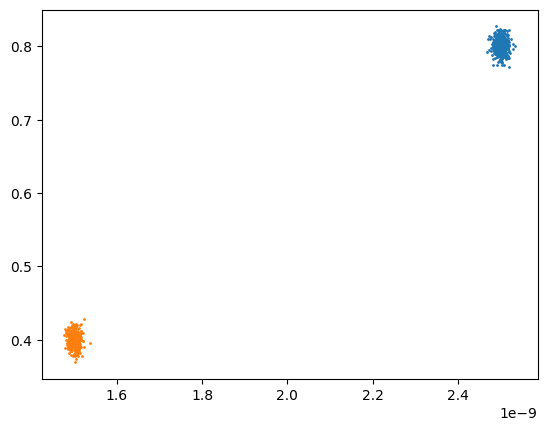

In [8]:
for clus in range(1,int(np.max(ROImask_gt)+1)):
    plt.plot(parameters_vector[ROImask_gt==clus,2],parameters_vector[ROImask_gt==clus,3],'o',markersize=1)

In [9]:
#get the saved hcp scheme
from dmipy.data import saved_acquisition_schemes

acq_scheme = saved_acquisition_schemes.wu_minn_hcp_acquisition_scheme()

In [10]:
#simulate the signal using the DIRECTIONAL model 

#snr = (10,20,30,40,50)

#snr = (10,20)


snr = (100,200)

signals = {}
signals_retest = {}

raw_signals = mc_mod.simulate_signal(acq_scheme,parameters_vector)

from useful_functions import add_noise

for i in snr:
    signals[i] = add_noise(raw_signals,snr=i)

    #also do a "retest" simulation - same underlying parameters but different noise
    signals_retest[i] = add_noise(raw_signals,snr=i)


In [11]:
# import nibabel as nib
# import os
# #save the simulations as nifti
# datadir = "/Users/paddyslator/OneDrive - University College London/data/bayes-dmipy/simdata"

# for i in snr:
        
#     #note that image is reshaped into 4D
#     img = nib.Nifti1Image(np.reshape(signals[i],(n_vox,1,1,acq_scheme.number_of_measurements)), np.eye(4))        
#     nib.save(img, os.path.join(datadir, 'simimg_test_nvox_' + str(n_vox) + '_snr_' + str(i) + '.nii.gz' ))  
    
#     img_retest = nib.Nifti1Image(np.reshape(signals_retest[i],(n_vox,1,1,acq_scheme.number_of_measurements)), np.eye(4))        
#     nib.save(img, os.path.join(datadir, 'simimg_retest_nvox_' + str(n_vox) + '_snr_' + str(i) + '.nii.gz' ))  
    


In [12]:
# import glob
# import os 
# simimgs = glob.glob(datadir + '/*')

# for img in simimgs:
#     img_path_shell = img.replace(" ", "\ ") 
#     #denoise the data!        
#     noise_map_path = img_path_shell.removesuffix('.nii.gz') + '_noise_map.nii.gz'
#     diff_denoised_path = img_path_shell.removesuffix('.nii.gz') + '_denoised.nii.gz'
    
#     os.system('dwidenoise -noise ' + noise_map_path + ' ' + img_path_shell + ' ' + diff_denoised_path)    

    



In [13]:
# #now load in the denoised and noise maps 
# signals_den = {}
# signals_retest_den = {}
# sigma = {}
# sigma_retest = {}


# for i in snr:    
#     img = nib.load(os.path.join(datadir, 'simimg_test_nvox_' + str(n_vox) + '_snr_' + str(i) + '_denoised.nii.gz' ))  
#     signals_den[i] = img.get_fdata()
#     signals_den[i] = np.reshape(signals_den[i],(n_vox,acq_scheme.number_of_measurements))
    
#     sigma_img = nib.load(os.path.join(datadir, 'simimg_test_nvox_' + str(n_vox) + '_snr_' + str(i) + '_noise_map.nii.gz' ))
#     sigma[i] = sigma_img.get_fdata()
#     sigma[i] = np.reshape(sigma[i],(n_vox))

    
#     img_retest = nib.load(os.path.join(datadir, 'simimg_retest_nvox_' + str(n_vox) + '_snr_' + str(i) + '_denoised.nii.gz' ))  
#     signals_retest_den[i] = img.get_fdata()
#     signals_retest_den[i] = np.reshape(signals_den[i],(n_vox,acq_scheme.number_of_measurements))

    
#     sigma_img_retest = nib.load(os.path.join(datadir, 'simimg_retest_nvox_' + str(n_vox) + '_snr_' + str(i) + '_noise_map.nii.gz' ))
#     sigma_retest[i] = sigma_img_retest.get_fdata()
#     sigma_retest[i] = np.reshape(sigma_retest[i],(n_vox))




In [14]:
# #rician correction
# signals_den_cor = {}
# signals_retest_den_cor = {}

# for i in snr:    
#     signals_den_cor[i] = np.sqrt(signals[i]**2 - (1/i)**2)
 
#     #signals_den_cor[i] = np.sqrt(np.abs(signals_den[i]**2 - np.tile(sigma[i]**2,(288,1)).T))
     
#     #signals_retest_den_cor[i] = np.sqrt(np.abs(signals_retest_den[i]**2 - np.tile(sigma_retest[i]**2,(288,1)).T))
        
    
#     signals_retest_den_cor[i] = np.sqrt(signals_retest[i]**2 - (1/i)**2)
    
    
# #save the corrected data
# for i in snr:
        
#     #note that image is reshaped into 4D
#     img = nib.Nifti1Image(np.reshape(signals_den_cor[i],(n_vox,1,1,acq_scheme.number_of_measurements)), np.eye(4))        
#     nib.save(img, os.path.join(datadir, 'simimg_test_nvox_' + str(n_vox) + '_snr_' + str(i) + '_denoised_rician_cor.nii.gz' ))  
    
#     img_retest = nib.Nifti1Image(np.reshape(signals_retest_den_cor[i],(n_vox,1,1,acq_scheme.number_of_measurements)), np.eye(4))        
#     nib.save(img, os.path.join(datadir, 'simimg_retest_nvox_' + str(n_vox) + '_snr_' + str(i) + '_denoised_rician_cor.nii.gz' ))  



In [15]:
# #use the corrected data 

# signals = signals_den_cor

# signals_retest = signals_retest_den_cor

In [16]:
# #calculate the ROImask using a diffusion tensor fit in dipy

# #set up the dipy aquisition
# from dipy.core.gradients import gradient_table
# gtab = gradient_table(acq_scheme.bvalues, acq_scheme.gradient_directions)

# #
# import dipy.reconst.dti as dti

# tenmodel = dti.TensorModel(gtab)

# tenfit = tenmodel.fit(signals)



In [17]:
# #threshold md and fa to estimate the ROImask
# md_thresh = 1e-9
# fa_thresh = 0.8

# ROImask = np.zeros_like(ROImask_gt)

# #white matter - less than md threshold and higher than fa threshold
# ROImask[(tenfit.md < md_thresh) & (tenfit.fa > fa_thresh)] = 1
# #grey matter - less than md threshold and less than fa threshold
# ROImask[(tenfit.md < md_thresh) & (tenfit.fa < fa_thresh)] = 2
# #csf - higher than md threshold and lower than fa threshold
# ROImask[(tenfit.md > md_thresh) & (tenfit.fa < fa_thresh)] = 3




In [18]:
#fit the MC spherical mean model (CHECK AGAINST DIRECTION AVERAGING FIRST?)

mc_smt_mod_lsq_fit = {}
mc_smt_mod_lsq_fit_retest = {}

for i in snr:
    print('fitting MC-SMT for SNR = ' + str(i))
    mc_smt_mod_lsq_fit[i] = mc_smt_mod.fit(acq_scheme, signals[i])

    mc_smt_mod_lsq_fit_retest[i] = mc_smt_mod.fit(acq_scheme, signals_retest[i])


fitting MC-SMT for SNR = 100
Using parallel processing with 10 workers.


/Users/paddyslator/.pyenv/versions/3.10.6/lib/python3.10/site-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'mu' of function 'unitsphere2cart_1d'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "dmipy/utils/utils.py", line 433:

def unitsphere2cart_1d(mu):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


Setup brute2fine optimizer in 0.17864131927490234 seconds


/Users/paddyslator/.pyenv/versions/3.10.6/lib/python3.10/site-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'mu' of function 'unitsphere2cart_1d'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "dmipy/utils/utils.py", line 433:

def unitsphere2cart_1d(mu):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/Users/paddyslator/.pyenv/versions/3.10.6/lib/python3.10/site-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'mu' of function 'unitsphere2cart_1d'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "dmipy/utils/utils

Fitting of 700 voxels complete in 2.3501269817352295 seconds.
Average of 0.0033573242596217565 seconds per voxel.
Using parallel processing with 10 workers.
Setup brute2fine optimizer in 0.005193948745727539 seconds
Fitting of 700 voxels complete in 2.0030126571655273 seconds.
Average of 0.0028614466530936106 seconds per voxel.
fitting MC-SMT for SNR = 200
Using parallel processing with 10 workers.
Setup brute2fine optimizer in 0.00849294662475586 seconds
Fitting of 700 voxels complete in 2.1895971298217773 seconds.
Average of 0.0031279958997453964 seconds per voxel.
Using parallel processing with 10 workers.
Setup brute2fine optimizer in 0.008422136306762695 seconds
Fitting of 700 voxels complete in 2.1001100540161133 seconds.
Average of 0.003000157220023019 seconds per voxel.


In [19]:
def estimate_ROIs_kmeans(parameters_vector,n_clusters):
    #cluster the voxels into ROIs using kmeans - could do this iteratively?
    from sklearn.cluster import KMeans
    import numpy as np
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(parameters_vector)
    
    ROImask = kmeans.labels_ + 1
    
    return ROImask, kmeans


def estimate_ROIs_gmm(parameters_vector,n_clusters):
    #cluster the voxels into ROIs using gmm 
    
    # training gaussian mixture model 
    from sklearn.mixture import GaussianMixture
    gmm = GaussianMixture(n_components=n_clusters)
    gmm.fit(parameters_vector)

    # #predictions from gmm
    ROImask = gmm.predict(parameters_vector) + 1
    
    return ROImask, gmm


def estimate_ROIs_spectral_clustering(parameters_vector,n_clusters):
    from sklearn.cluster import SpectralClustering
    # create instance of model and fit to data
    spectral_clustering = SpectralClustering(n_clusters)
    spectral_clustering.fit(parameters_vector)

    # 
    ROImask = spectral_clustering.labels_ + 1

    return ROImask, spectral_clustering


#use the ground truth number of ROIs
n_clusters=n_ROI

ROImask = {}
ROImask_retest = {}

ROImaskspec = {}
ROImask_retestspec = {}


for i in snr:
    #do it for the test
    ROImask[i],_ = estimate_ROIs_gmm(mc_smt_mod_lsq_fit[i].fitted_parameters_vector, n_clusters)
    #do it for the retest
    ROImask_retest[i],_ = estimate_ROIs_gmm(mc_smt_mod_lsq_fit_retest[i].fitted_parameters_vector, n_clusters)
    

    
    
#     print('JUST USING ONES FOR THE ROI MASK')
#     ROImask[i] = np.ones(np.shape(ROImask[i]))
#     ROImask_retest[i] = np.ones(np.shape(ROImask_retest[i]))





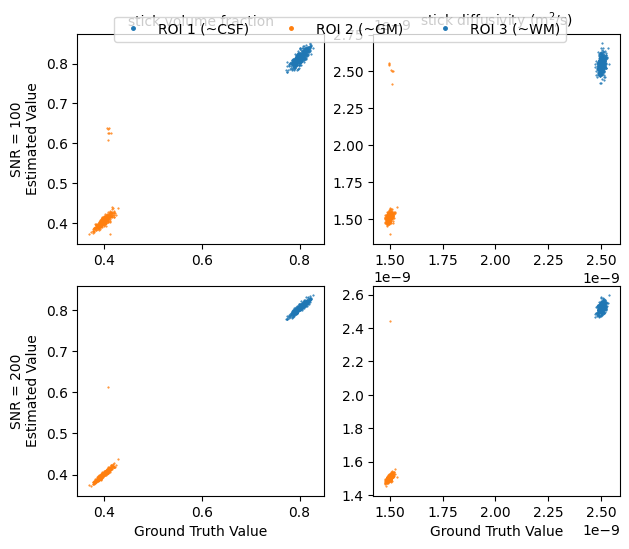

In [20]:
#estimated vs. gt parameters coloured by gt ROI 

# short_param_names = ('stick volume fraction','stick diffusivity (m$^2$/s)')


# fig, axs = plt.subplots(len(snr), 2, figsize=[7,3*len(snr)])


# for i,plt_i in zip(snr,range(0,len(snr))):
#     for roi in range(0,int(np.max(ROImask_gt))+1):
#         axs[plt_i,0].plot(f_stick[ROImask_gt==roi],mc_smt_mod_lsq_fit[i].fitted_parameters['BundleModel_1_partial_volume_0'][ROImask_gt==roi],'o',markersize=1)

#         axs[plt_i,1].plot(lambda_par[ROImask_gt==roi],mc_smt_mod_lsq_fit[i].fitted_parameters['BundleModel_1_G2Zeppelin_1_lambda_par'][ROImask_gt==roi],'o',markersize=1)    

#         #TO DO calculate MSE, bias, variance




#         axs[plt_i,0].set_ylabel('SNR = ' + str(i) + '\nEstimated Value')


#         if plt_i==0:
#             axs[plt_i,0].set_title(short_param_names[0],fontsize=10)
#             axs[plt_i,1].set_title(short_param_names[1],fontsize=10)


#         if plt_i==len(snr)-1:
#             axs[plt_i,0].set_xlabel('Ground Truth Value')
#             axs[plt_i,1].set_xlabel('Ground Truth Value')





# #add legend
# leg = fig.legend(('White matter 1','Grey matter', 'CSF', 'White matter 2'), 
#            loc='upper center',ncol=2,
#             bbox_to_anchor=(0.5, 0.94))

    
#


def plot_gt_v_est(f_stick,lambda_par,ROImask,mc_smt_mod_fit_dict):
    short_param_names = ('stick volume fraction','stick diffusivity (m$^2$/s)')

    
    snr = mc_smt_mod_fit_dict.keys()
    
    fig, axs = plt.subplots(len(snr), 2, figsize=[7,3*len(snr)])

    
    
    #plot some single points first to get the legend correct
#     for roi in range(1,int(np.max(ROImask_gt))+1):
#         first_roi_index = np.where(ROImask_gt==roi)[0][0]
#         axs[0,0].plot(f_stick[first_roi_index],mc_smt_mod_lsq_fit[10].fitted_parameters['BundleModel_1_partial_volume_0'][first_roi_index],'o',markersize=1)
        

    for i,plt_i in zip(snr,range(0,len(snr))):
        for roi in range(1,int(np.max(ROImask_gt))+1):
            axs[plt_i,0].plot(f_stick[ROImask_gt==roi],mc_smt_mod_lsq_fit[i].fitted_parameters['BundleModel_1_partial_volume_0'][ROImask_gt==roi],'o',markersize=0.5)

            axs[plt_i,1].plot(lambda_par[ROImask_gt==roi],mc_smt_mod_lsq_fit[i].fitted_parameters['BundleModel_1_G2Zeppelin_1_lambda_par'][ROImask_gt==roi],'o',markersize=0.5)    

            #TO DO calculate MSE, bias, variance


            axs[plt_i,0].set_ylabel('SNR = ' + str(i) + '\nEstimated Value')


            if plt_i==0:
                axs[plt_i,0].set_title(short_param_names[0],fontsize=10)
                axs[plt_i,1].set_title(short_param_names[1],fontsize=10)


            if plt_i==len(snr)-1:
                axs[plt_i,0].set_xlabel('Ground Truth Value')
                axs[plt_i,1].set_xlabel('Ground Truth Value')






    
    
    #add legend
    leg = fig.legend(('ROI 1 (~CSF)','ROI 2 (~GM)', 'ROI 3 (~WM)'), 
               loc='upper center',ncol=3,
                bbox_to_anchor=(0.5, 0.92),
                markerscale=5.)
    
    

plot_gt_v_est(f_stick,lambda_par,ROImask_gt,mc_smt_mod_lsq_fit)




#axs[0].set_xlim([0,1])
#axs[0].set_ylim([0,1])

In [21]:
# np.shape(mc_smt_mod_lsq_fit.fitted_parameters['BundleModel_1_partial_volume_0'][ROImask==roi])
# np.shape(mc_smt_mod_lsq_fit_retest.fitted_parameters['BundleModel_1_partial_volume_0'][ROImask_retest==roi])

In [22]:
#test-retest plot 

# fig, axs = plt.subplots(1, 2, figsize=[10, 5])

# for roi in range(0,int(np.max(ROImask))+1):
#     axs[0].plot(mc_smt_mod_lsq_fit.fitted_parameters['BundleModel_1_partial_volume_0'][ROImask_gt==roi],
#                 mc_smt_mod_lsq_fit_retest.fitted_parameters['BundleModel_1_partial_volume_0'][ROImask_gt==roi],'o',markersize=1)
        
#     axs[1].plot(mc_smt_mod_lsq_fit.fitted_parameters['BundleModel_1_G2Zeppelin_1_lambda_par'][ROImask_gt==roi],
#                 mc_smt_mod_lsq_fit_retest.fitted_parameters['BundleModel_1_G2Zeppelin_1_lambda_par'][ROImask_gt==roi],'o',markersize=1)    

    
    
# print("Plot colours show the ground truth ROIs")
    

In [23]:
from useful_functions import create_spherical_mean_scheme
from dmipy.utils import spherical_mean

acq_scheme_smt = create_spherical_mean_scheme(acq_scheme)

signals_sm = {}
signals_sm_retest = {}

for j in snr:
    #signals_sm = np.asarray([spherical_mean.estimate_spherical_mean_multi_shell(signals, acq_scheme) ] 
    signals_sm[j] = np.asarray([spherical_mean.estimate_spherical_mean_multi_shell(signals[j][i,:], acq_scheme) for i in range(0,n_vox)])

    signals_sm_retest[j] = np.asarray([spherical_mean.estimate_spherical_mean_multi_shell(signals_retest[j][i,:], acq_scheme) for i in range(0,n_vox)])





In [24]:
E_fit = {}
E_fit_retest = {}

for i in snr:
    E_fit[i] = mc_smt_mod.simulate_signal(acq_scheme_smt,mc_smt_mod_lsq_fit[i].fitted_parameters_vector)

    E_fit_retest[i] = mc_smt_mod.simulate_signal(acq_scheme_smt,mc_smt_mod_lsq_fit_retest[i].fitted_parameters_vector)



In [25]:
import time 
import fit_bayes_new


nsteps=1000
burn_in=500
nupdates=20

parameters_bayes_dict={}
acceptance_rate={} 
parameter_convergence={}
likelihood={} 
weights={}
accepted_per_n={}
gibbs_mu={}
gibbs_sigma={}

parameters_bayes_dict_retest={} 
acceptance_rate_retest={}
parameter_convergence_retest={}
likelihood_retest={} 
weights_retest={}
accepted_per_n_retest={}
gibbs_mu_retest={}
gibbs_sigma_retest={}
    
for i in snr:
    # hierarchical Bayesian fitting
    #proc_start = time.time()
    parameters_bayes_dict[i], acceptance_rate[i], parameter_convergence[i], likelihood[i], weights[i], gibbs_mu[i], gibbs_sigma[i]\
        = fit_bayes_new.fit(mc_smt_mod, acq_scheme_smt, signals_sm[i], E_fit[i], mc_smt_mod_lsq_fit[i].fitted_parameters, ROImask[i], nsteps, burn_in, nupdates)
#     parameters_bayes_dict[i], acceptance_rate[i], parameter_convergence[i], likelihood[i], weights[i], accepted_per_n[i]\
#          = fit_bayes_new.fit(mc_smt_mod, acq_scheme_smt, signals_sm[i], E_fit[i], mc_smt_mod_lsq_fit[i].fitted_parameters, ROImask_gt, nsteps, burn_in, nupdates)


    #compute_time(proc_start, time.time())

    #retest
    parameters_bayes_dict_retest[i], acceptance_rate_retest[i], parameter_convergence_retest[i], likelihood_retest[i], weights_retest[i], gibbs_mu[i], gibbs_sigma[i]\
       = fit_bayes_new.fit(mc_smt_mod, acq_scheme_smt, signals_sm_retest[i], E_fit_retest[i], mc_smt_mod_lsq_fit_retest[i].fitted_parameters, ROImask_retest[i], nsteps, burn_in, nupdates)




 >> at start of fit_bayes.fit
 >> extracting ROIs
 >> setting up dictionary
BundleModel_1_G2Zeppelin_1_lambda_par
BundleModel_1_partial_volume_0
 >> setting up weights
 >> initialising dictionaries
26
26
 >> starting loop
ROI 1/2; 407 voxels
ROI 1/2; mcmc step = 0/1000
ROI 1/2; mcmc step = 100/1000
ROI 1/2; mcmc step = 200/1000
ROI 1/2; mcmc step = 300/1000
ROI 1/2; mcmc step = 400/1000
ROI 1/2; mcmc step = 500/1000
ROI 1/2; mcmc step = 600/1000
ROI 1/2; mcmc step = 700/1000
ROI 1/2; mcmc step = 800/1000
ROI 1/2; mcmc step = 900/1000
ROI 2/2; 293 voxels
ROI 2/2; mcmc step = 0/1000
ROI 2/2; mcmc step = 100/1000
ROI 2/2; mcmc step = 200/1000
ROI 2/2; mcmc step = 300/1000
ROI 2/2; mcmc step = 400/1000
ROI 2/2; mcmc step = 500/1000
ROI 2/2; mcmc step = 600/1000
ROI 2/2; mcmc step = 700/1000
ROI 2/2; mcmc step = 800/1000
ROI 2/2; mcmc step = 900/1000
 >> at start of fit_bayes.fit
 >> extracting ROIs
 >> setting up dictionary
BundleModel_1_G2Zeppelin_1_lambda_par
BundleModel_1_partial_volume

In [26]:
#extract the ROI prior parameters and transform them 

gibbs_mu_dict = {}
gibbs_mu_dict_t = {}

gibbs_sigma_dict = {}
gibbs_sigma_dict_t = {}


for i in snr:
    #means
    gibbs_mu_dict[i] = {}

    gibbs_mu_dict[i]['BundleModel_1_G2Zeppelin_1_lambda_par'] = np.zeros((n_clusters,nsteps))
    gibbs_mu_dict[i]['BundleModel_1_partial_volume_0'] = np.zeros((n_clusters,nsteps))
        

    #calculate the variances for the diagonal elements only
    gibbs_sigma_dict[i] = {}
    
    gibbs_sigma_dict[i]['BundleModel_1_G2Zeppelin_1_lambda_par'] = np.zeros((n_clusters,nsteps))
    gibbs_sigma_dict[i]['BundleModel_1_partial_volume_0'] = np.zeros((n_clusters,nsteps))

    

    for j in range(0,n_clusters):
        gibbs_mu_dict[i]['BundleModel_1_G2Zeppelin_1_lambda_par'][j,:] = gibbs_mu[i][j,1,:]
        gibbs_mu_dict[i]['BundleModel_1_partial_volume_0'][j,:] = gibbs_mu[i][j,0,:]

        gibbs_sigma_dict[i]['BundleModel_1_G2Zeppelin_1_lambda_par'][j,:] = gibbs_sigma[i][j,1,1,:]
        gibbs_sigma_dict[i]['BundleModel_1_partial_volume_0'][j,:] = gibbs_sigma[i][j,0,0,:]

            
            
    #transformed version - have to do a lot of messing about with dictionaries!
    gibbs_mu_dict_t[i] = {} 
    
    gibbs_mu_dict_t[i]['BundleModel_1_G2Zeppelin_1_lambda_par'] = np.zeros((n_clusters,nsteps))
    gibbs_mu_dict_t[i]['BundleModel_1_partial_volume_0'] = np.zeros((n_clusters,nsteps))

    
    gibbs_sigma_dict_t[i] = {}
    
    gibbs_sigma_dict_t[i]['BundleModel_1_G2Zeppelin_1_lambda_par'] = np.zeros((n_clusters,nsteps))
    gibbs_sigma_dict_t[i]['BundleModel_1_partial_volume_0'] = np.zeros((n_clusters,nsteps))

    
    for j in range(0,n_clusters):
        #mean
        tmp_mu_dict = {}
        tmp_mu_dict['BundleModel_1_G2Zeppelin_1_lambda_par'] = gibbs_mu_dict[i]['BundleModel_1_G2Zeppelin_1_lambda_par'][j,:]
        tmp_mu_dict['BundleModel_1_partial_volume_0'] = gibbs_mu_dict[i]['BundleModel_1_partial_volume_0'][j,:]
            
        tmp_gibbs_mu_dict_t = fit_bayes_new.tform_params(tmp_mu_dict, mc_smt_mod.parameter_names, mc_smt_mod, 'r')
        
        gibbs_mu_dict_t[i]['BundleModel_1_G2Zeppelin_1_lambda_par'][j,:] = tmp_gibbs_mu_dict_t['BundleModel_1_G2Zeppelin_1_lambda_par']
        gibbs_mu_dict_t[i]['BundleModel_1_partial_volume_0'][j,:] = tmp_gibbs_mu_dict_t['BundleModel_1_partial_volume_0']
        
        #covariance
        tmp_sigma_dict = {}
        tmp_sigma_dict['BundleModel_1_G2Zeppelin_1_lambda_par'] = gibbs_sigma_dict[i]['BundleModel_1_G2Zeppelin_1_lambda_par'][j,:]
        tmp_sigma_dict['BundleModel_1_partial_volume_0'] = gibbs_sigma_dict[i]['BundleModel_1_partial_volume_0'][j,:]

        #transform the standard deviation then square it?
#         tmp_sigma_dict['BundleModel_1_G2Zeppelin_1_lambda_par'] = np.sqrt(tmp_sigma_dict['BundleModel_1_G2Zeppelin_1_lambda_par'])
#         tmp_sigma_dict['BundleModel_1_partial_volume_0'] = np.sqrt(gibbs_sigma_dict[i]['BundleModel_1_partial_volume_0'][j,:])
        
        tmp_sigma_dict_t = fit_bayes_new.tform_params(tmp_sigma_dict, mc_smt_mod.parameter_names, mc_smt_mod, 'r')

#         tmp_sigma_dict_t['BundleModel_1_G2Zeppelin_1_lambda_par'] = (tmp_sigma_dict['BundleModel_1_G2Zeppelin_1_lambda_par'])**2
#         tmp_sigma_dict_t['BundleModel_1_partial_volume_0'] = (gibbs_sigma_dict[i]['BundleModel_1_partial_volume_0'][j,:])**2

        
        gibbs_sigma_dict_t[i]['BundleModel_1_G2Zeppelin_1_lambda_par'][j,:] = tmp_sigma_dict_t['BundleModel_1_G2Zeppelin_1_lambda_par']
        gibbs_sigma_dict_t[i]['BundleModel_1_partial_volume_0'][j,:] = tmp_sigma_dict_t['BundleModel_1_partial_volume_0']

        



In [27]:
np.shape(gibbs_sigma_dict_t[snr[0]]['BundleModel_1_G2Zeppelin_1_lambda_par'])

(2, 1000)

In [28]:
#VARIANCES ARE TOO HIGH? SOMETHING ABOUT THE TRANSFORMATION - IS IT THE SAME TO TRANSFORM A SQUARED PARAMETER?


#definately something wrong when transforming the standard deviation!

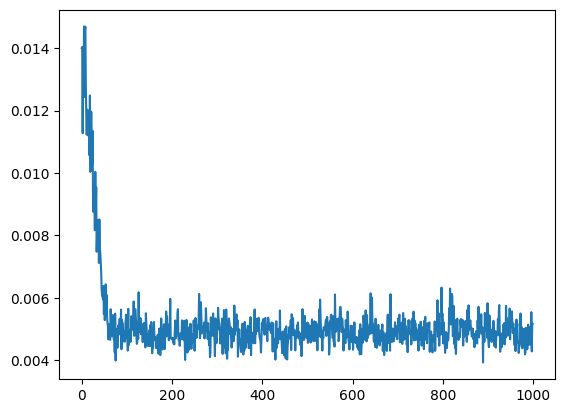

In [29]:
plt.plot(gibbs_sigma_dict[snr[1]]['BundleModel_1_G2Zeppelin_1_lambda_par'][0,:])


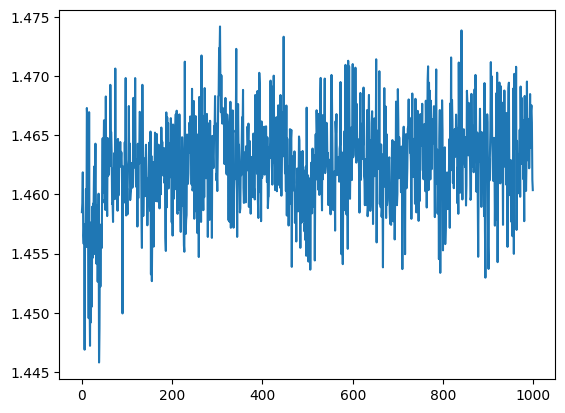

In [30]:
plt.plot(gibbs_mu_dict[snr[1]]['BundleModel_1_G2Zeppelin_1_lambda_par'][0,:])

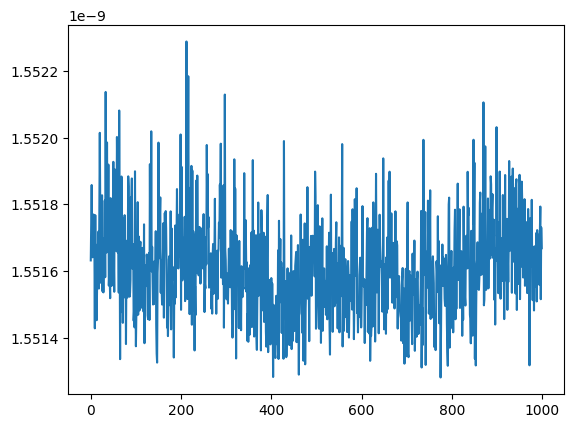

In [31]:
plt.plot(gibbs_sigma_dict_t[snr[1]]['BundleModel_1_G2Zeppelin_1_lambda_par'][1,:])


Looks like this samples mu with the correct standard deviation, but cant calculate the actual std properly!


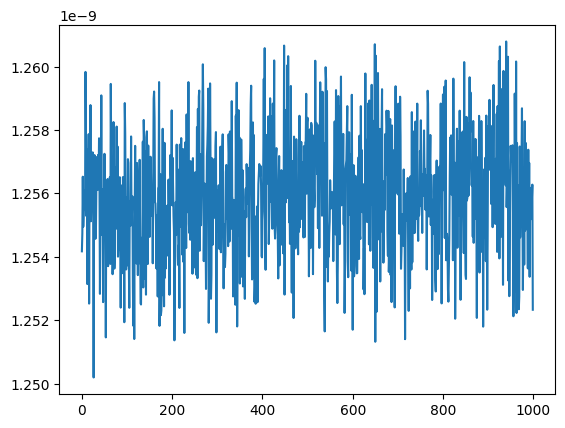

In [32]:
plt.plot(gibbs_mu_dict_t[snr[1]]['BundleModel_1_G2Zeppelin_1_lambda_par'][1,:])

print('Looks like this samples mu with the correct standard deviation, but cant calculate the actual std properly!')


In [37]:
print('WORKS TO HERE')

WORKS TO HERE


In [33]:
np.shape(gibbs_sigma_dict[i]['BundleModel_1_G2Zeppelin_1_lambda_par'])

(2, 1000)

In [34]:
#calculate the mean Gibbs parameters
gibbs_mu_est_dict={}
gibbs_sigma_est_dict={}

for i in snr:
    gibbs_mu_est_dict[i]={}
    gibbs_sigma_est_dict[i]={}
#    gibbs_mu_dict[i][param] = gibbs_mu[i][:,j,burn_in:-1]
#    gibbs_sigma_dict[i][param] = gibbs_sigma[i][:,:,:,burn_in:-1]
        
    gibbs_mu_est_dict[i]['BundleModel_1_G2Zeppelin_1_lambda_par'] = np.mean(gibbs_mu_dict[i]['BundleModel_1_G2Zeppelin_1_lambda_par'],axis=1)
    gibbs_mu_est_dict[i]['BundleModel_1_partial_volume_0'] = np.mean(gibbs_mu_dict[i]['BundleModel_1_partial_volume_0'],axis=1)
    
    gibbs_sigma_est_dict[i]['BundleModel_1_G2Zeppelin_1_lambda_par'] = np.mean(gibbs_sigma_dict[i]['BundleModel_1_G2Zeppelin_1_lambda_par'],axis=1)
    gibbs_sigma_est_dict[i]['BundleModel_1_partial_volume_0'] = np.mean(gibbs_sigma_dict[i]['BundleModel_1_partial_volume_0'],axis=1)




In [35]:
gibbs_mu_est_dict[100]

{'BundleModel_1_G2Zeppelin_1_lambda_par': array([-0.39832503,  1.5302804 ]),
 'BundleModel_1_partial_volume_0': array([-0.05440152,  1.70596602])}

In [36]:
import scipy

MVN_prior={}

for i in snr:
        MVN_prior[i]={}
        for roi in range(1,int(np.max(ROImask_gt))+1):
            MVN_prior[i][roi] = scipy.stats.multivariate_normal(gibbs_mu_est_dict[i][roi-1,:], gibbs_sigma_dict[i][roi-1,:,:], allow_singular=1)




            

TypeError: unhashable type: 'slice'

In [ ]:
N = 500
X = np.linspace(-100, 100, N)
Y = np.linspace(-5, 5, N)
X, Y = np.meshgrid(X, Y)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

# The distribution on the variables X, Y packed into pos.
Z = MVN_prior[i][1].pdf(pos)

# Create a surface plot and projected filled contour plot under it.
# fig = plt.figure()
# ax = fig.gca(projection='3d')
# ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
#                 cmap='viridis')

plt.contour(X, Y, Z)

fit_bayes_new.tform_params

locs = {}
labels = {}

locs['BundleModel_1_partial_volume_0'], labels['BundleModel_1_partial_volume_0'] = plt.xticks()
locs['BundleModel_1_G2Zeppelin_1_lambda_par'], labels['BundleModel_1_G2Zeppelin_1_lambda_par'] = plt.yticks()

labels = fit_bayes_new.tform_params(locs, mc_smt_mod.parameter_names, mc_smt_mod, 'r')

# for params in labels.keys():
#     labels[params] = np.round(labels[params])

plt.xticks(locs['BundleModel_1_partial_volume_0'], labels['BundleModel_1_partial_volume_0'],rotation=90)
plt.yticks(locs['BundleModel_1_G2Zeppelin_1_lambda_par'], labels['BundleModel_1_G2Zeppelin_1_lambda_par'])

# labels = [float(item)*5 for item in locs]
# plt.xticks(locs, labels)



# def tform_params(param_dict, parameter_names, model, direction):
#     param_dict = deepcopy(param_dict)  # because dicts are mutable, and don't want to alter inside function
#     if direction == 'f':
#         for param in parameter_names:
#             if '_mu' not in param:  # don't transform orientation parameters
#                 # NB. Add/subtract 1e-5 to avoid nan/inf if parameter is on upper/lower bound from LS fit. Transformed
#                 # parameters shouldn't ever reach bounds (i.e. from sampling in Metropolis Hastings step)
#                 lb = (model.parameter_ranges[param][0] - 1e-5) * model.parameter_scales[param]  # lower bound
#                 ub = (model.parameter_ranges[param][1] + 1e-5) * model.parameter_scales[param]  # upper bound
#                 # lb = (model.parameter_ranges[param][0] - np.finfo(np.float32).eps) * model.parameter_scales[param]  # lower bound
#                 # ub = (model.parameter_ranges[param][1] + np.finfo(np.float32).eps) * model.parameter_scales[param]  # upper bound
#                 param_dict[param] = np.log(param_dict[param] - lb) - np.log(ub - param_dict[param])



In [ ]:
np.exp(locs['BundleModel_1_partial_volume_0'])

In [ ]:
x = np.linspace(-10,10,500)
y = np.linspace(-10,10,500)
X, Y = np.meshgrid(x,y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y

plt.hist(MVN_prior[10][roi].pdf())

In [ ]:
nsteps=10000
print(nsteps/10)
for j in range(0, nsteps):
    if np.mod(nsteps/10,j)==0:
        print(j)


In [ ]:
#plt.plot(mc_smt_mod_lsq_fit[snr[0]].fitted_parameters['BundleModel_1_partial_volume_0'],parameters_bayes_dict[snr[0]]['BundleModel_1_partial_volume_0'],'x',markersize=0.1)

#mc_smt_mod_lsq_fit.fitted_parameters['BundleModel_1_G2Zeppelin_1_lambda_par']


# fig, axs = plt.subplots(1, 2, figsize=[10, 5])

# for roi in range(0,int(np.max(ROImask_gt))+1):
#     axs[0].plot(f_stick[ROImask_gt==roi],parameters_bayes_dict[50]['BundleModel_1_partial_volume_0'][ROImask_gt==roi],'o',markersize=1)
        
#     axs[1].plot(lambda_par[ROImask_gt==roi],parameters_bayes_dict[50]['BundleModel_1_G2Zeppelin_1_lambda_par'][ROImask_gt==roi],'o',markersize=1)    
    
# #    MSE['BundleModel_1_partial_volume_0'][roi] = 
# #    MSE['BundleModel_1_G2Zeppelin_1_lambda_par'][roi] = 

# axs[0].set_xlim([0,1])
# axs[0].set_ylim([0,1])

In [ ]:
plot_gt_v_est(f_stick,lambda_par,ROImask_gt,parameters_bayes_dict)





In [ ]:
for clus in range(1,int(np.max(ROImask_gt)+1)):
#    plt.plot(parameters_vector[ROImask_gt==clus,2],parameters_vector[ROImask_gt==clus,3],'o',markersize=1)    
    plt.plot(mc_smt_mod_lsq_fit[snr[0]].fitted_parameters['BundleModel_1_G2Zeppelin_1_lambda_par'][ROImask[snr[0]]==clus],mc_smt_mod_lsq_fit[snr[0]].fitted_parameters['BundleModel_1_partial_volume_0'][ROImask[snr[0]]==clus],'o',markersize=1)


In [ ]:
i=1
for clus in range(1,int(np.max(ROImask_gt)+1)):
#    plt.plot(parameters_vector[ROImask_gt==clus,2],parameters_vector[ROImask_gt==clus,3],'o',markersize=1)    
    plt.plot(parameters_bayes_dict[snr[i]]['BundleModel_1_G2Zeppelin_1_lambda_par'][ROImask_gt==clus],parameters_bayes_dict[snr[i]]['BundleModel_1_partial_volume_0'][ROImask_gt==clus],'x',markersize=5)
    
    
    
    
    
    
         
         
         

In [ ]:
for clus in range(1,int(np.max(ROImask_gt)+1)):
#    plt.plot(parameters_vector[ROImask_gt==clus,2],parameters_vector[ROImask_gt==clus,3],'o',markersize=1)    
    plt.plot(parameters_bayes_dict[snr[0]]['BundleModel_1_G2Zeppelin_1_lambda_par'][ROImask[snr[0]]==clus],parameters_bayes_dict[snr[0]]['BundleModel_1_partial_volume_0'][ROImask[snr[0]]==clus],'o',markersize=1)
         
         
         

In [ ]:
plt.plot(ROImask_gt)
plt.plot(ROImask[snr[0]],'x',markersize=1)

In [ ]:
np.sum(ROImask_gt == ROImask[snr[0]])/len(ROImask_gt)

In [ ]:
#test-retest plots - plot lsq on the same plot
# fig, axs = plt.subplots(2, 2, figsize=[10, 10])

# for roi in range(0,int(np.max(ROImask))+1):
    
#     axs[0,0].plot(mc_smt_mod_lsq_fit.fitted_parameters['BundleModel_1_partial_volume_0'][ROImask_gt==roi],
#                 mc_smt_mod_lsq_fit_retest.fitted_parameters['BundleModel_1_partial_volume_0'][ROImask_gt==roi],'o',markersize=1)
        
#     axs[0,1].plot(mc_smt_mod_lsq_fit.fitted_parameters['BundleModel_1_G2Zeppelin_1_lambda_par'][ROImask_gt==roi],
#                 mc_smt_mod_lsq_fit_retest.fitted_parameters['BundleModel_1_G2Zeppelin_1_lambda_par'][ROImask_gt==roi],'o',markersize=1)    

    
#     #Bayesian
#     axs[1,0].plot(parameters_bayes_dict['BundleModel_1_partial_volume_0'][ROImask_gt==roi],
#                 parameters_bayes_dict_retest['BundleModel_1_partial_volume_0'][ROImask_gt==roi],
#                 'o',markersize=1)
        
#     axs[1,1].plot(parameters_bayes_dict['BundleModel_1_G2Zeppelin_1_lambda_par'][ROImask_gt==roi],
#                 parameters_bayes_dict_retest['BundleModel_1_G2Zeppelin_1_lambda_par'][ROImask_gt==roi],
#                 'o',markersize=1)    

    
 




In [ ]:
import matplotlib.pyplot as plt
import numpy as np    
    
def bland_altman_plot(data1, data2, *args, **kwargs):
    mean = np.mean([data1, data2], axis=0)
    diff = data1 - data2                   # Difference between data1 and data2
    md      = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')
    
    

In [ ]:
#Bland-Altman plots


#test-retest plots 
fig, axs = plt.subplots(len(snr)*2, 2, figsize=[10,10*len(snr)])


for j,plt_j in zip(snr,range(0,len(snr))):
    for roi in range(1,int(np.max(ROImask_gt))+1):
        for param, i in zip(mc_smt_mod_lsq_fit[j].fitted_parameters.keys(), range(0,len(mc_smt_mod_lsq_fit[j].fitted_parameters))):
                     
            this_plot = 2*plt_j + i 
            
            #Least squares
            mean = np.mean([mc_smt_mod_lsq_fit[j].fitted_parameters[param][ROImask_gt==roi],
                        mc_smt_mod_lsq_fit_retest[j].fitted_parameters[param][ROImask_gt==roi]],axis=0)

            diff = mc_smt_mod_lsq_fit[j].fitted_parameters[param][ROImask_gt==roi] - \
                        mc_smt_mod_lsq_fit_retest[j].fitted_parameters[param][ROImask_gt==roi]

            axs[this_plot,0].plot(mean, diff, 'o', markersize=1)

    #         #plot mean of the difference for each ROI separately 
    #         axs[i,0].axhline(np.mean(diff), color='gray', linestyle='--')
    #         axs[i,0].axhline(np.mean(diff)  + 1.96*np.std(diff, axis=0), color='gray', linestyle='--')
    #         axs[i,0].axhline(np.mean(diff)  - 1.96*np.std(diff, axis=0), color='gray', linestyle='--')


            #Bayesian
            mean = np.mean([parameters_bayes_dict[j][param][ROImask_gt==roi],
                        parameters_bayes_dict_retest[j][param][ROImask_gt==roi]],axis=0)

            diff = parameters_bayes_dict[j][param][ROImask_gt==roi] - \
                        parameters_bayes_dict_retest[j][param][ROImask_gt==roi]

            axs[this_plot,1].plot(mean, diff, 'o', markersize=1)

            #for easy comparison, make the bayesian y-axis limits the same as the LSQ        
            axs[this_plot,1].set_ylim(axs[this_plot,0].get_ylim())


    #         #plot mean of the difference for each ROI separately 
    #         axs[i,1].axhline(np.mean(diff), color='gray', linestyle='--')
    #         axs[i,1].axhline(np.mean(diff)  + 1.96*np.std(diff, axis=0), color='gray', linestyle='--')
    #         axs[i,1].axhline(np.mean(diff)  - 1.96*np.std(diff, axis=0), color='gray', linestyle='--')


    #add labels
    axs[0,0].set_title('Least Squares')
    axs[0,1].set_title('Bayesian')

    for param, i in zip(mc_smt_mod_lsq_fit[j].fitted_parameters.keys(), range(0,len(mc_smt_mod_lsq_fit[j].fitted_parameters))):
        this_plot = 2*plt_j + i 

        axs[this_plot,0].set_ylabel(param)
        axs[this_plot,0].set_ylabel(param)



    #plot mean and sd of the difference for all voxels together 

    #LSQ
    # mean = np.mean([mc_smt_mod_lsq_fit.fitted_parameters[param],
    #             mc_smt_mod_lsq_fit_retest.fitted_parameters[param]],axis=0)

    for param, i in zip(mc_smt_mod_lsq_fit[j].fitted_parameters.keys(), range(0,len(mc_smt_mod_lsq_fit[j].fitted_parameters))):
        this_plot = 2*plt_j + i 

        diff = mc_smt_mod_lsq_fit[j].fitted_parameters[param] - \
                    mc_smt_mod_lsq_fit_retest[j].fitted_parameters[param]

        axs[this_plot,0].axhline(np.mean(diff), color='gray', linestyle='--')
        axs[this_plot,0].axhline(np.mean(diff)  + 1.96*np.std(diff, axis=0), color='gray', linestyle='--')
        axs[this_plot,0].axhline(np.mean(diff)  - 1.96*np.std(diff, axis=0), color='gray', linestyle='--')

        #Bayesian
        diff = parameters_bayes_dict[j][param] - \
                    parameters_bayes_dict_retest[j][param]        
        axs[this_plot,1].axhline(np.mean(diff), color='gray', linestyle='--')
        axs[this_plot,1].axhline(np.mean(diff)  + 1.96*np.std(diff, axis=0), color='gray', linestyle='--')
        axs[this_plot,1].axhline(np.mean(diff)  - 1.96*np.std(diff, axis=0), color='gray', linestyle='--')



# #create Bland-Altman plot                  
# f, ax = plt.subplots(1, figsize = (8,5))
# sm.graphics.mean_diff_plot(df.A, df.B, ax = ax)

# #display Bland-Altman plot
# plt.show()

In [ ]:
ROIs

In [ ]:
#calculate MSE, bias, variance etc.

def mean_squared_error(x,y):
    return ((x - y)**2).mean(axis=0)

def calculate_mean_bias(gt,pred):
    return np.mean(gt - pred)
    
def calculate_variance(gt,pred):
    return (np.std(gt - pred))**2

def calculate_bias(gt,pred):
    return gt - pred

MSE = {}
mean_bias = {}
bias = {}
variance = {}

MSE_lsq = {}
mean_bias_lsq = {}
bias_lsq = {}
variance_lsq = {}

for i in snr:
    MSE[i] = {}
    MSE_lsq[i] = {}
    for roi in range(1,int(np.max(ROImask_gt))+1):
        MSE[i][roi] = {}
        MSE_lsq[i][roi] = {}
    
        MSE[i][roi]['BundleModel_1_partial_volume_0'] = mean_squared_error(f_stick[ROImask_gt==roi],parameters_bayes_dict[i]['BundleModel_1_partial_volume_0'][ROImask_gt==roi])
        MSE_lsq[i][roi]['BundleModel_1_partial_volume_0'] = mean_squared_error(f_stick[ROImask_gt==roi],mc_smt_mod_lsq_fit[i].fitted_parameters['BundleModel_1_partial_volume_0'][ROImask_gt==roi])

        MSE[i][roi]['BundleModel_1_G2Zeppelin_1_lambda_par'] = mean_squared_error(f_stick[ROImask_gt==roi],parameters_bayes_dict[i]['BundleModel_1_G2Zeppelin_1_lambda_par'][ROImask_gt==roi])
        MSE_lsq[i][roi]['BundleModel_1_G2Zeppelin_1_lambda_par'] = mean_squared_error(f_stick[ROImask_gt==roi],mc_smt_mod_lsq_fit[i].fitted_parameters['BundleModel_1_G2Zeppelin_1_lambda_par'][ROImask_gt==roi])

        
 #       BundleModel_1_G2Zeppelin_1_lambda_par
        
        
#        plot_gt_v_est(f_stick,lambda_par,mc_smt_mod_lsq_fit)
        


In [ ]:
print(MSE[10][1])
print(MSE_lsq[10][1])


In [ ]:

i=10

print(f_stick[i])
print(lambda_par[i])

noise=snr[1]

fig, axs = plt.subplots(4,2)

axs[0,0].plot(parameter_convergence[noise]['BundleModel_1_partial_volume_0'][i,:])
axs[0,0].scatter(0,f_stick[i],marker='x',color='r')
axs[0,0].scatter(0,mc_smt_mod_lsq_fit[noise].fitted_parameters['BundleModel_1_partial_volume_0'][i],marker='x',color='g')


axs[1,0].plot(acceptance_rate[noise][i,:])


axs[2,0].plot(weights[noise]['BundleModel_1_partial_volume_0'][i,:])


axs[3,0].plot(likelihood[noise][i,:])


axs[0,1].plot(parameter_convergence[noise]['BundleModel_1_G2Zeppelin_1_lambda_par'][i,:])
axs[0,1].scatter(0,lambda_par[i],marker='x',color='r')
axs[0,1].scatter(0,mc_smt_mod_lsq_fit[noise].fitted_parameters['BundleModel_1_G2Zeppelin_1_lambda_par'][i],marker='x',color='g')


axs[1,1].plot(acceptance_rate[noise][i,:])


axs[2,1].plot(weights[noise]['BundleModel_1_G2Zeppelin_1_lambda_par'][i,:])


    

In [ ]:
print(parameters_bayes_dict[noise]['BundleModel_1_partial_volume_0'][i])
print(parameters_bayes_dict_retest[noise]['BundleModel_1_partial_volume_0'][272])
print(f_stick[272])
print(mc_smt_mod_lsq_fit[noise].fitted_parameters['BundleModel_1_partial_volume_0'][272])
print(mc_smt_mod_lsq_fit_retest[noise].fitted_parameters['BundleModel_1_partial_volume_0'][272])

In [ ]:
print(weights[noise]['BundleModel_1_G2Zeppelin_1_lambda_par'][i,:])


In [ ]:
parameters_bayes_dict[noise]['BundleModel_1_G2Zeppelin_1_lambda_par']

In [ ]:
fig, axs = plt.subplots(2,2)

noise=snr[0]
i=100

axs[0,1].hist(parameter_convergence[noise]['BundleModel_1_G2Zeppelin_1_lambda_par'][i,:],bins=50,histtype=u'step', density=True)
axs[0,1].scatter(lambda_par[i],0,marker='x',zorder=100,clip_on=False)
axs[0,1].scatter(mc_smt_mod_lsq_fit[noise].fitted_parameters['BundleModel_1_G2Zeppelin_1_lambda_par'][i],0,marker='o',zorder=100,clip_on=False)
axs[0,1].scatter(parameters_bayes_dict[noise]['BundleModel_1_G2Zeppelin_1_lambda_par'][i],0,marker='s',zorder=100,clip_on=False)




In [ ]:
PLOT THE POSTERIOR ABOVE

#plt.plot(weights[1000]['BundleModel_1_G2Zeppelin_1_lambda_par'])

In [ ]:
#THESE ARE THE COVARIANCE WEIGHTS!!!
np.shape(weights[10]['BundleModel_1_G2Zeppelin_1_lambda_par'])

In [ ]:
#calculate the contrast to noise ratios, remember WM = 1, GM = 2, CSF =3

# def calculate_CNR(ROI1,ROI2):
#     mean_ROI1 = np.mean(ROI1)
#     mean_ROI2 = np.mean(ROI2)
    
#     var_ROI1 = np.var(ROI1)
#     var_ROI2 = np.var(ROI2)
    
#     CNR = np.abs(mean_ROI1 - mean_ROI2)/np.sqrt(var_ROI1 + var_ROI2)
    
#     return CNR

# CNR_LSQ={}
# CNR_Bayes={}
    
# for param, i in zip(mc_smt_mod_lsq_fit.fitted_parameters.keys(), range(0,len(mc_smt_mod_lsq_fit.fitted_parameters))):
#     #LSQ


# #     mean_WM = np.mean(mc_smt_mod_lsq_fit.fitted_parameters[param][ROImask==1])
# #     mean_GM = np.mean(mc_smt_mod_lsq_fit.fitted_parameters[param][ROImask==2])
# #     mean_CSF = np.mean(mc_smt_mod_lsq_fit.fitted_parameters[param][ROImask==3])
    
# #     sd_WM = np.std(mc_smt_mod_lsq_fit.fitted_parameters[param][ROImask==1])
# #     sd_GM = np.std(mc_smt_mod_lsq_fit.fitted_parameters[param][ROImask==2])
# #     sd_CSF = np.std(mc_smt_mod_lsq_fit.fitted_parameters[param][ROImask==3])
    

#     CNR_LSQ[param] = np.zeros(len(mc_smt_mod_lsq_fit.fitted_parameters)+1)
#     CNR_Bayes[param] = np.zeros(len(mc_smt_mod_lsq_fit.fitted_parameters)+1)

    
#     #between white and grey matter 
#     CNR_LSQ[param][0] = calculate_CNR(mc_smt_mod_lsq_fit.fitted_parameters[param][ROImask==1],\
#                                      mc_smt_mod_lsq_fit.fitted_parameters[param][ROImask==2])

#     #between white matter and CSF
#     CNR_LSQ[param][1] = calculate_CNR(mc_smt_mod_lsq_fit.fitted_parameters[param][ROImask==1],\
#                                      mc_smt_mod_lsq_fit.fitted_parameters[param][ROImask==3])
 
#     #between grey matter and CSF
#     CNR_LSQ[param][2] = calculate_CNR(mc_smt_mod_lsq_fit.fitted_parameters[param][ROImask==2],\
#                                      mc_smt_mod_lsq_fit.fitted_parameters[param][ROImask==3])
 

#     #Bayesian
    
#     #between white and grey matter 
#     CNR_Bayes[param][0] = calculate_CNR(parameters_bayes_dict[param][ROImask==1],
#                                      parameters_bayes_dict[param][ROImask==2])

#     #between white matter and CSF
#     CNR_Bayes[param][1] = calculate_CNR(parameters_bayes_dict[param][ROImask==1],
#                                      parameters_bayes_dict[param][ROImask==3])
 
#     #between grey matter and CSF
#     CNR_Bayes[param][2] = calculate_CNR(parameters_bayes_dict[param][ROImask==2],
#                                      parameters_bayes_dict[param][ROImask==3])

    
    

In [ ]:
#calculate the contrast to noise ratios, remember WM = 1, GM = 2, CSF =3, WM2 = 4

def calculate_CNR(ROI1,ROI2):
    mean_ROI1 = np.mean(ROI1)
    mean_ROI2 = np.mean(ROI2)
    
    var_ROI1 = np.var(ROI1)
    var_ROI2 = np.var(ROI2)
    
    CNR = np.abs(mean_ROI1 - mean_ROI2)/np.sqrt(var_ROI1 + var_ROI2)
    
    return CNR

CNR_LSQ={}
CNR_Bayes={}

nbars = 3

for param, i in zip(mc_smt_mod_lsq_fit[j].fitted_parameters.keys(), range(0,len(mc_smt_mod_lsq_fit[j].fitted_parameters))):
    #LSQ  
        CNR_LSQ[param]={}
        CNR_Bayes[param]={}

    #     mean_WM = np.mean(mc_smt_mod_lsq_fit.fitted_parameters[param][ROImask==1])
    #     mean_GM = np.mean(mc_smt_mod_lsq_fit.fitted_parameters[param][ROImask==2])
    #     mean_CSF = np.mean(mc_smt_mod_lsq_fit.fitted_parameters[param][ROImask==3])

    #     sd_WM = np.std(mc_smt_mod_lsq_fit.fitted_parameters[param][ROImask==1])
    #     sd_GM = np.std(mc_smt_mod_lsq_fit.fitted_parameters[param][ROImask==2])
    #     sd_CSF = np.std(mc_smt_mod_lsq_fit.fitted_parameters[param][ROImask==3])

        
        for j in snr:            
            CNR_LSQ[param][j] = np.zeros(nbars)
            CNR_Bayes[param][j] = np.zeros(nbars)


            #between WM1 and grey matter 
            CNR_LSQ[param][j][0] = calculate_CNR(mc_smt_mod_lsq_fit[j].fitted_parameters[param][ROImask_gt==1],\
                                             mc_smt_mod_lsq_fit[j].fitted_parameters[param][ROImask_gt==2])

            #between WM1 and CSF
            CNR_LSQ[param][j][1] = calculate_CNR(mc_smt_mod_lsq_fit[j].fitted_parameters[param][ROImask_gt==1],\
                                             mc_smt_mod_lsq_fit[j].fitted_parameters[param][ROImask_gt==3])

            #between grey matter and CSF
            CNR_LSQ[param][j][2] = calculate_CNR(mc_smt_mod_lsq_fit[j].fitted_parameters[param][ROImask_gt==2],\
                                             mc_smt_mod_lsq_fit[j].fitted_parameters[param][ROImask_gt==3])


            #between WM1 and WM2 
#             CNR_LSQ[param][j][3] = calculate_CNR(mc_smt_mod_lsq_fit[j].fitted_parameters[param][ROImask_gt==1],\
#                                              mc_smt_mod_lsq_fit[j].fitted_parameters[param][ROImask_gt==4])

#             #between grey matter and WM2
#             CNR_LSQ[param][j][4] = calculate_CNR(mc_smt_mod_lsq_fit[j].fitted_parameters[param][ROImask_gt==2],\
#                                              mc_smt_mod_lsq_fit[j].fitted_parameters[param][ROImask_gt==4])


#             #between CSF and WM2
#             CNR_LSQ[param][j][5] = calculate_CNR(mc_smt_mod_lsq_fit[j].fitted_parameters[param][ROImask_gt==3],\
#                                          mc_smt_mod_lsq_fit[j].fitted_parameters[param][ROImask_gt==4])


            #Bayesian

            #between white and grey matter 
            CNR_Bayes[param][j][0] = calculate_CNR(parameters_bayes_dict[j][param][ROImask_gt==1],
                                             parameters_bayes_dict[j][param][ROImask_gt==2])

            #between white matter and CSF
            CNR_Bayes[param][j][1] = calculate_CNR(parameters_bayes_dict[j][param][ROImask_gt==1],
                                             parameters_bayes_dict[j][param][ROImask_gt==3])

            #between grey matter and CSF
            CNR_Bayes[param][j][2] = calculate_CNR(parameters_bayes_dict[j][param][ROImask_gt==2],
                                             parameters_bayes_dict[j][param][ROImask_gt==3])


#             #between WM1 and WM2 
#             CNR_Bayes[param][j][3] = calculate_CNR(parameters_bayes_dict[j][param][ROImask_gt==1],\
#                                              parameters_bayes_dict[j][param][ROImask_gt==4])

#             #between grey matter and WM2
#             CNR_Bayes[param][j][4] = calculate_CNR(parameters_bayes_dict[j][param][ROImask_gt==2],\
#                                              parameters_bayes_dict[j][param][ROImask_gt==4])


#             #between CSF and WM2
#             CNR_Bayes[param][j][5] = calculate_CNR(parameters_bayes_dict[j][param][ROImask_gt==3],\
#                                          parameters_bayes_dict[j][param][ROImask_gt==4])







In [ ]:
#plot the CNRs


fig, axs = plt.subplots(1, 2, figsize=[12, 5])

bar_width = 0.35

nbars = 3

LSQ_bars = np.arange(nbars)
Bayes_bars = [x + bar_width for x in LSQ_bars]

j=snr[0]

for param, i in zip(mc_smt_mod_lsq_fit[j].fitted_parameters.keys(), range(0,len(mc_smt_mod_lsq_fit[j].fitted_parameters))):
    axs[i].bar(LSQ_bars,CNR_LSQ[param][j],width=bar_width, label='Least Squares')
    axs[i].bar(Bayes_bars,CNR_Bayes[param][j],width=bar_width, label='Bayesian')

    axs[i].legend()

    axs[i].set_ylabel('Contrast-to-Noise Ratio')

    #axs[i].set_xticklabels('')
    axs[i].set_xticks([r + bar_width/2 for r in range(nbars)])
#    axs[i].set_xticklabels(['WM:GM','WM:CSF','GM:CSF','WM:WM2','GM:WM2','CSF:WM2'])
    
    #axs[i].set_xticklabels(['WM:GM','WM:CSF','GM:CSF','WM:WM2','GM:WM2','CSF:WM2'])
    
    
    axs[i].set_title(param)

#['WM:GM','WM:CSF','GM:CSF']

#plt.bar(np.arange(3),data)

In [ ]:
# fig, axs = plt.subplots(1, 2, figsize=[12, 5])

# bar_width = 0.35

# nbars = 3

# LSQ_bars = np.arange(3)
# Bayes_bars = [x + bar_width for x in LSQ_bars]

# for param, i in zip(mc_smt_mod_lsq_fit.fitted_parameters.keys(), range(0,len(mc_smt_mod_lsq_fit.fitted_parameters))):
#     axs[i].bar(LSQ_bars,CNR_LSQ[param],width=bar_width, label='Least Squares')
#     axs[i].bar(Bayes_bars,CNR_Bayes[param],width=bar_width, label='Bayesian')

#     axs[i].legend()

#     axs[i].set_ylabel('Contrast-to-Noise Ratio')

#     #axs[i].set_xticklabels('')
#     axs[i].set_xticks([r + bar_width/2 for r in range(nbars)])
#     axs[i].set_xticklabels(['WM:GM','WM:CSF','GM:CSF'])
    
#     axs[i].set_title(param)

# #['WM:GM','WM:CSF','GM:CSF']

# #plt.bar(np.arange(3),data)

In [ ]:
[r + bar_width/2 for r in range(nbars)]

In [ ]:
mc_smt_mod_lsq_fit.fitted_parameters['BundleModel_1_G2Zeppelin_1_lambda_par']

In [ ]:
#make the ground truth parameters into an image - can just do this last!
np.sum(ROImask_gt==1)

np.sqrt(300)

fig, axs = plt.subplots(2, 2, figsize=[10, 12])

image_shape = (36,25)

for param, i in zip(mc_smt_mod_lsq_fit.fitted_parameters.keys(), range(0,len(mc_smt_mod_lsq_fit.fitted_parameters))):
#    axs[0,1].imshow(np.reshape(ROImask_gt,image_shape))

    #LSQ
    im=axs[i,0].imshow(np.reshape(mc_smt_mod_lsq_fit.fitted_parameters[param],image_shape))
    fig.colorbar(im,ax=axs[i,0])

    #Bayesian
    im=axs[i,1].imshow(np.reshape(parameters_bayes_dict[param],image_shape))
    fig.colorbar(im,ax=axs[i,1])


        
#add labels
axs[0,0].set_title('Least Squares')
axs[0,1].set_title('Bayesian')

for param, i in zip(mc_smt_mod_lsq_fit.fitted_parameters.keys(), range(0,len(mc_smt_mod_lsq_fit.fitted_parameters))):
    axs[i,0].set_ylabel(param)
    axs[i,0].set_ylabel(param)
    

In [ ]:
weights

In [ ]:
#TO DO CALCULATE BIAS AND VARIANCE


#Paddy to do: 1. test-restest simulations; 2. "lesion" simulation
#Paddy. 3. rois based on clustering from lsq fit - can do kmeans etc, might need a bit of tuning but should be ok



In [ ]:

# #uniform distribution with min/max values
# # lambda_par_wm = [2e-9, 3e-9]
# # lambda_par_gm = [1e-9, 2e-9]
# # lambda_par_csf = [2.9e-9, 3e-9]

# #lambda_par_wm2 = [2e-9, 2.5e-9]

# # lambda_par_wm = [2.9e-9, 3e-9]
# # lambda_par_gm = [2.9e-9, 3e-9]
# # lambda_par_csf = [2.9e-9, 3e-9]

# #f_stick_wm = [0.5, 0.8]
# #f_stick_gm = [0.2, 0.5]
# #f_stick_csf = [0, 0.05]






# #f_stick_wm2 = [0.7, 0.9]

# # f_stick_wm = [0.95, 1]
# # f_stick_gm = [0.95, 1]
# # f_stick_csf = [0.95, 1]



# # lambda_par = np.concatenate((np.random.uniform(low=lambda_par_wm[0],high=lambda_par_wm[1], size = n_wm),
# #                       np.random.uniform(low=lambda_par_gm[0],high=lambda_par_gm[1], size = n_gm),
# #                       np.random.uniform(low=lambda_par_csf[0],high=lambda_par_csf[1], size = n_csf)    ))
              
# # f_stick = np.concatenate((np.random.uniform(low=f_stick_wm[0],high=f_stick_wm[1], size = n_wm),
# #                       np.random.uniform(low=f_stick_gm[0],high=f_stick_gm[1], size = n_gm),
# #                       np.random.uniform(low=f_stick_csf[0],high=f_stick_csf[1], size = n_csf)  ))

# lambda_par = np.concatenate((np.random.normal(loc=np.mean(lambda_par_wm),scale=0.15e-9, size = n_wm),
#                       np.random.normal(loc=np.mean(lambda_par_gm),scale=0.15e-9, size = n_gm),
#                       np.random.normal(loc=np.mean(lambda_par_csf),scale=.02e-9, size = n_csf)))
# #                      np.random.normal(loc=np.mean(lambda_par_wm2),scale=.1e-9, size = n_wm2) ))
              
# f_stick = np.concatenate((np.random.normal(loc=np.mean(f_stick_wm),scale=0.08, size = n_wm),
#                       np.random.normal(loc=np.mean(f_stick_gm),scale=0.08, size = n_gm),
#                       np.random.normal(loc=np.mean(f_stick_csf),scale=0.005, size = n_csf)))
# #                      np.random.normal(loc=np.mean(f_stick_wm2),scale=0.04, size = n_wm2)  ))
                                 


# f_free = 1 - f_stick



# # stick_par = np.concatenate((np.random.uniform(low=stick_par_wm[0],high=stick_par_wm[1], size = n_wm),
# #                       np.random.uniform(low=stick_par_gm[0],high=stick_par_gm[1], size = n_gm),
# #                       np.random.uniform(low=stick_par_csf[0],high=stick_par_csf[1], size = n_csf)))




# #put into a big parameter vector that can be passed into simulate_signal
# parameters_vector = mc_mod.parameters_to_parameter_vector(BundleModel_1_G2Zeppelin_1_mu=mu,
#                                                                 BundleModel_1_G2Zeppelin_1_lambda_par=lambda_par,
#                                                                 BundleModel_1_partial_volume_0=f_stick)
                                                        




# 